# Imports

In [304]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, ColorJitter, ToPILImage
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score


In [305]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Loading Images

In [306]:
real_data_dir = "./Stanford_Cars/stanford-cars-real-train-fewshot"
synthetic_data_dir = "./Stanford_Cars/stanford-cars-synthetic-classwise-16/synthetic_16"
img_size = (320, 320)  # Resize images to 320x320 pixels

In [307]:
# Function to load images and labels from a given directory
def load_dataset(directory, img_size=(320, 320)):
    data, labels = [], []
    class_names = sorted(os.listdir(directory))  # Sort class folders alphabetically
    class_map = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue  # Skip if not a directory

        for filename in os.listdir(class_path):
            if filename.lower().endswith((".jpg", ".jpeg", ".png")):
                file_path = os.path.join(class_path, filename)
                image = cv2.imread(file_path, cv2.IMREAD_COLOR)
                if image is not None:
                    # Preprocess image
                    image = cv2.resize(image, img_size)  # Resize image
                    image = image.astype('float32') / 255.0  # Normalize pixel values
                    data.append(image)
                    labels.append(class_map[class_name])

    return np.array(data), np.array(labels), class_map

In [308]:
# Load datasets
real_images, real_labels, real_class_map = load_dataset(real_data_dir, img_size)
synthetic_images, synthetic_labels, synthetic_class_map = load_dataset(synthetic_data_dir, img_size)

In [309]:
print(real_labels)

[  1   1   1 ... 196 196 196]


In [310]:
print(f"Loaded {len(real_images)} real images and {len(synthetic_images)} synthetic images.")
print(f"Number of classes: {len(real_class_map)}")


Loaded 3120 real images and 3120 synthetic images.
Number of classes: 197


In [311]:
# Verify that class mappings are consistent across both datasets
assert real_class_map == synthetic_class_map, "Class mappings do not match between real and synthetic datasets."

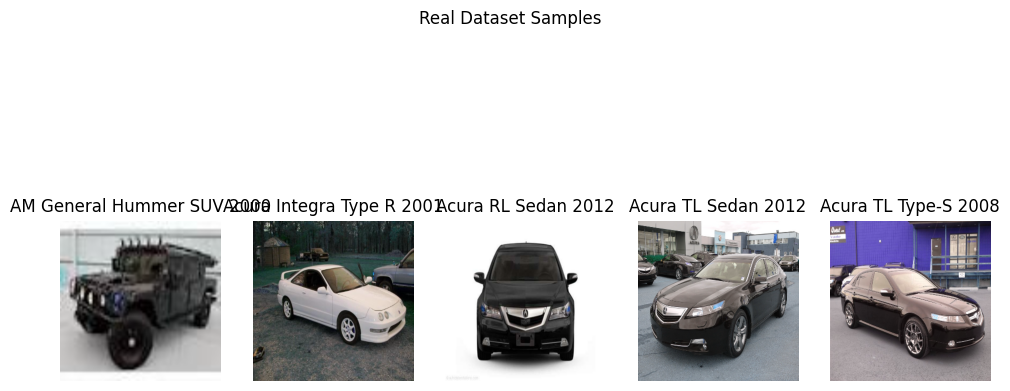

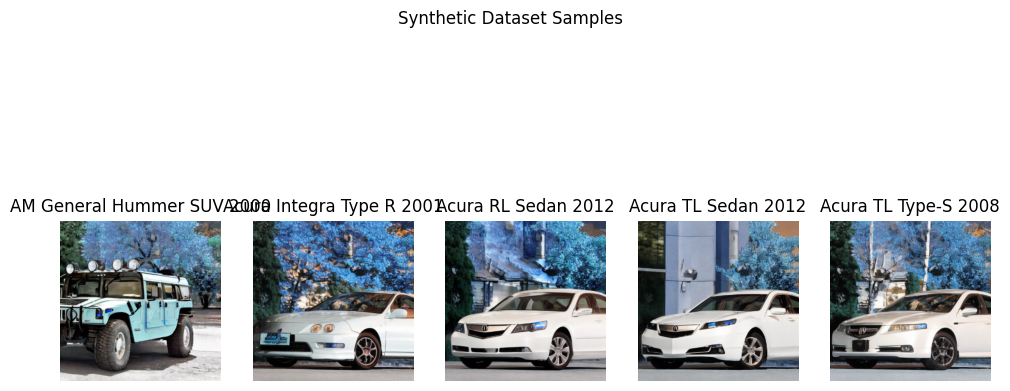

In [312]:
def display_samples(images, labels, class_map, title="Sample Images"):
    plt.figure(figsize=(12, 6))
    unique_labels = np.unique(labels)
    for i, label in enumerate(unique_labels[:5]):  # Display samples from up to 5 different classes
        idx = np.where(labels == label)[0][0]
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[idx])
        plt.title(list(class_map.keys())[list(class_map.values()).index(label)])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display samples from the real dataset
display_samples(real_images, real_labels, real_class_map, title="Real Dataset Samples")

# Display samples from the synthetic dataset
display_samples(synthetic_images, synthetic_labels, synthetic_class_map, title="Synthetic Dataset Samples")

# Model Creation

In [313]:
class RealFakeClassifier(nn.Module):
    def __init__(self):
        super(RealFakeClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Downsample by 2
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # Adjust input size based on image resolution
        self.fc2 = nn.Linear(256, 1)  # Binary classification
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)  # Flatten for fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x

In [ ]:
# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RealFakeClassifier().to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)


#With Optimizer Adam and BCELoss
#I don't rememebr the result for lr=1e-05, weight_decay=1e-4
#Test Accuracy: 0.6586538461538461 for lr=1e-05, weight_decay=1e-3
#Test Accuracy: 0.7756410256410257 for lr=0.001, weight_decay=1e-4
#Test Accuracy: 0.6650641025641025 for lr=0.001, weight_decay=1e-3
#Test Accuracy: 0.5769230769230769 for lr=0.001, weight_decay=1e-5



#With Optimizer AdamW and BCEWithLogitsLoss
#Test Accuracy: 0.7355769230769231 for lr=0.001, weight_decay=1e-4


# Dataset Handling

In [ ]:
class RealFakeDataset(Dataset):
    def __init__(self, images, labels, class_map, is_real, transform=None):
        """
        Args:
            images (numpy.ndarray): Array of image data.
            labels (numpy.ndarray): Corresponding class labels.
            class_map (dict): Mapping from class names to indices.
            is_real (bool): Whether this dataset is for real (True) or synthetic (False) images.
            transform (callable, optional): Transform to be applied on the images.
        """
        self.images = images
        self.labels = labels
        self.class_map = class_map
        self.binary_label = 0 if is_real else 1 
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.binary_label 

        if self.transform:
            image = self.transform(image)

        return image, label

In [316]:
# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),            
    transforms.Resize((128, 128)),       
    RandomHorizontalFlip(),
    RandomRotation(20),
    ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),               # Convert image to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

In [317]:
# Prepare datasets
real_dataset = RealFakeDataset(real_images, real_labels, real_class_map, is_real=True, transform=transform)
synthetic_dataset = RealFakeDataset(synthetic_images, synthetic_labels, synthetic_class_map, is_real=False, transform=transform)

# Combine real and synthetic datasets
combined_dataset = torch.utils.data.ConcatDataset([real_dataset, synthetic_dataset])

In [318]:
len(combined_dataset)

6240

In [319]:
total_size = len(combined_dataset)
val_test_size = int(0.2 * total_size)  # 20% for validation + test
train_size = total_size - val_test_size
train_dataset, val_test_dataset = random_split(combined_dataset, [train_size, val_test_size])

# Further split val_test_dataset into validation and test sets
val_size = len(val_test_dataset) // 2
test_size = len(val_test_dataset) - val_size
val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])


In [320]:
len(train_dataset)

4992

In [321]:
len(val_test_dataset)

1248

In [322]:
len(val_dataset)

624

In [323]:
len(test_dataset)

624

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
test_augment = Compose([
    ToPILImage(),            
    transforms.Resize((128, 128)),       
    RandomHorizontalFlip(),
    RandomRotation(20),
    ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),              
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

augmented_test_images = []
augmented_test_labels = []

for image, label in test_dataset:
    augmented_image = test_augment(image)
    augmented_test_images.append(augmented_image)
    augmented_test_labels.append(label)

augmented_test_loader = DataLoader(
    list(zip(augmented_test_images, augmented_test_labels)),
    batch_size=32,
    shuffle=False
)

# Training and Validation

In [326]:
num_epochs = 20 
train_losses = []
val_losses = []
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0


    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    val_losses.append(running_loss / len(val_loader))
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
    scheduler.step()

for param_group in optimizer.param_groups:
    print("Final Learning Rate:", param_group['lr'])

Epoch [1/20], Train Loss: 0.4224, Val Loss: 0.2985
Epoch [2/20], Train Loss: 0.2442, Val Loss: 0.1591
Epoch [3/20], Train Loss: 0.1540, Val Loss: 0.1296
Epoch [4/20], Train Loss: 0.1296, Val Loss: 0.0913
Epoch [5/20], Train Loss: 0.0932, Val Loss: 0.0837
Epoch [6/20], Train Loss: 0.0650, Val Loss: 0.0624
Epoch [7/20], Train Loss: 0.0566, Val Loss: 0.0510
Epoch [8/20], Train Loss: 0.0445, Val Loss: 0.0536
Epoch [9/20], Train Loss: 0.0448, Val Loss: 0.0319
Epoch [10/20], Train Loss: 0.0345, Val Loss: 0.0403
Epoch [11/20], Train Loss: 0.0365, Val Loss: 0.0332
Epoch [12/20], Train Loss: 0.0311, Val Loss: 0.0405
Epoch [13/20], Train Loss: 0.0314, Val Loss: 0.0466
Epoch [14/20], Train Loss: 0.0298, Val Loss: 0.0388
Epoch [15/20], Train Loss: 0.0323, Val Loss: 0.0309
Epoch [16/20], Train Loss: 0.0375, Val Loss: 0.0502
Epoch [17/20], Train Loss: 0.0335, Val Loss: 0.0463
Epoch [18/20], Train Loss: 0.0366, Val Loss: 0.0345
Epoch [19/20], Train Loss: 0.0315, Val Loss: 0.0501
Epoch [20/20], Train 

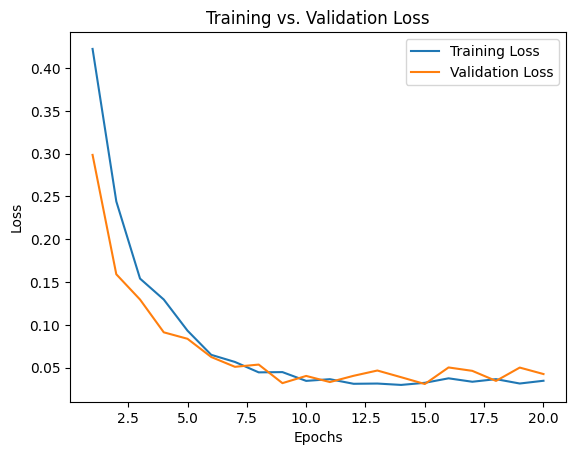

In [327]:
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()

In [328]:
# Validation loop
model.eval()
y_true = []
y_pred = []
y_probs = []

with torch.no_grad(): 
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = (outputs > 0.5).float() 
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(outputs.cpu().numpy()) 

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))


Accuracy: 0.9823717948717948
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       317
           1       0.97      0.99      0.98       307

    accuracy                           0.98       624
   macro avg       0.98      0.98      0.98       624
weighted avg       0.98      0.98      0.98       624



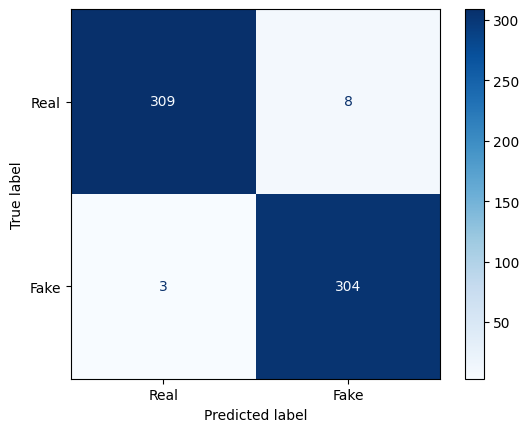

In [329]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [330]:
y_true = np.array(y_true)
y_probs = np.array(y_probs).flatten()  # Flatten to match dimensions

print(f"y_true shape: {y_true.shape}, y_probs shape: {y_probs.shape}")

y_true shape: (624,), y_probs shape: (624,)


In [331]:
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=["Real", "Fake"]))

auc_roc = roc_auc_score(y_true, y_probs)
print("AUC-ROC:", auc_roc)


Classification Report:
               precision    recall  f1-score   support

        Real       0.99      0.97      0.98       317
        Fake       0.97      0.99      0.98       307

    accuracy                           0.98       624
   macro avg       0.98      0.98      0.98       624
weighted avg       0.98      0.98      0.98       624

AUC-ROC: 0.9994348482824525


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.94509804].


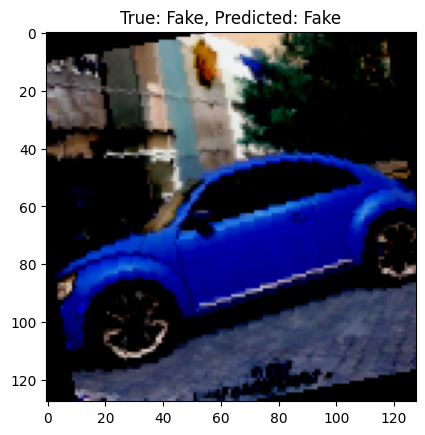

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


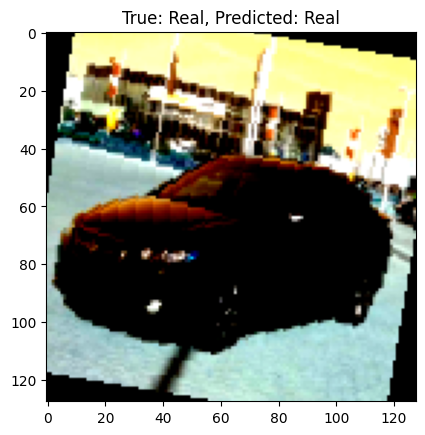

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88235295..0.7490196].


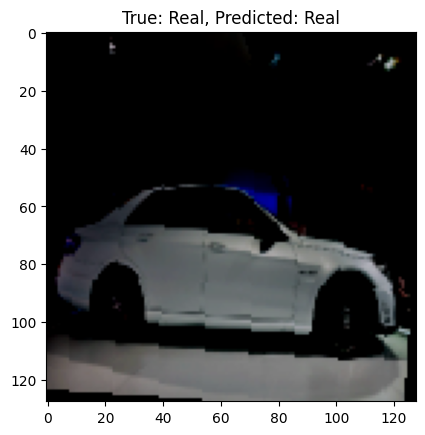

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8117647].


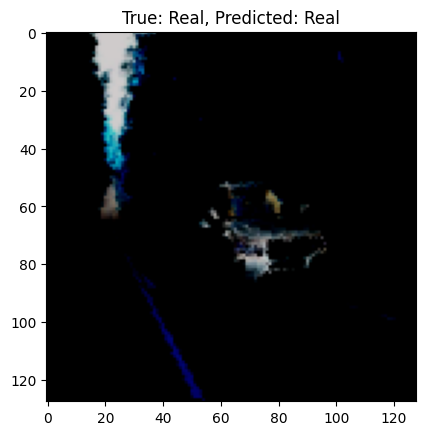

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].


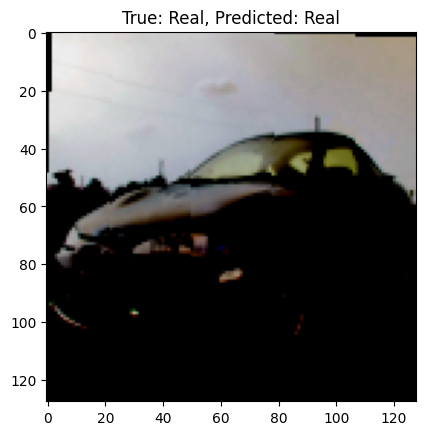

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6627451].


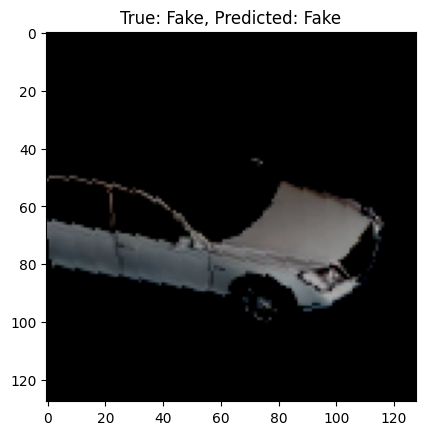

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..0.8352941].


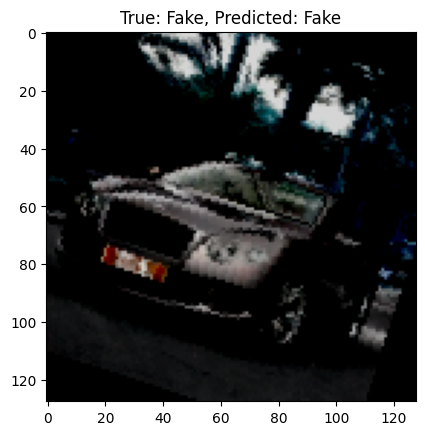

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.5764706].


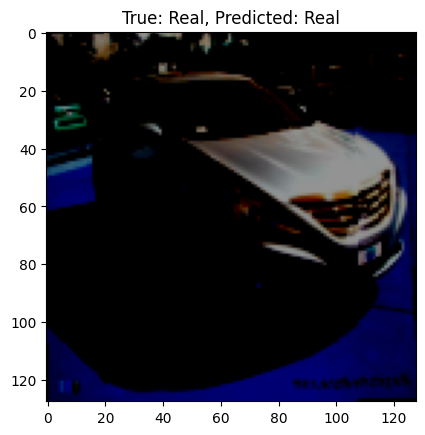

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


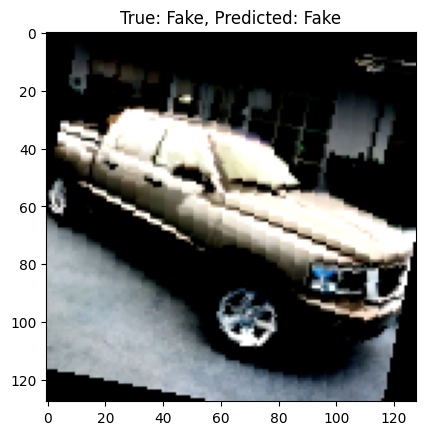

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


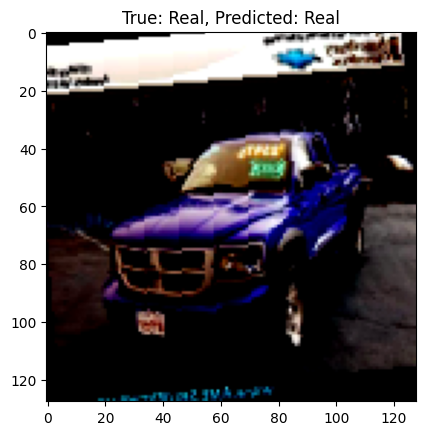

In [332]:
# Visualize some predictions
for i in range(10):
    image = val_dataset[i][0] 
    label = val_dataset[i][1] 
    prediction = model(image.unsqueeze(0).to(device)).item()
    
    plt.imshow(image.permute(1, 2, 0).cpu().numpy()) 
    plt.title(f"True: {'Real' if label == 0 else 'Fake'}, Predicted: {'Real' if prediction < 0.5 else 'Fake'}")
    plt.show()

# Testing Loop

In [333]:
# Evaluate on normal test set
print("Evaluating on Normal Test Set...")
y_true, y_pred, y_probs = [], [], []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        y_probs.extend(outputs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        y_pred.extend((outputs > 0.5).float().cpu().numpy())

print("Classification Report (Normal Test Set):")
print("Test Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=["Real", "Fake"]))
print("AUC-ROC:", roc_auc_score(y_true, y_probs))

Evaluating on Normal Test Set...
Classification Report (Normal Test Set):
Test Accuracy: 0.9871794871794872
Classification Report:
               precision    recall  f1-score   support

        Real       0.99      0.98      0.99       321
        Fake       0.98      0.99      0.99       303

    accuracy                           0.99       624
   macro avg       0.99      0.99      0.99       624
weighted avg       0.99      0.99      0.99       624

AUC-ROC: 0.9997429649507007


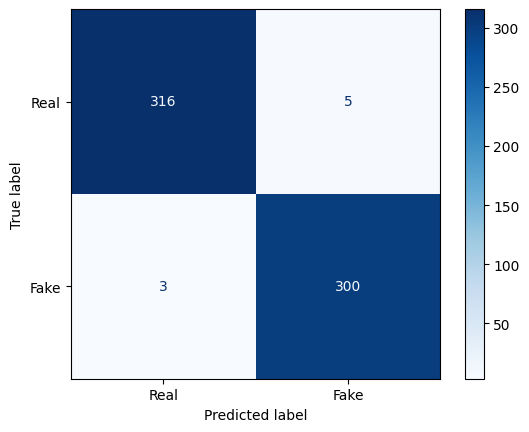

In [334]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [335]:
# Evaluate on augmented test set
print("Evaluating on Augmented Test Set...")
y_true_aug, y_pred_aug, y_probs_aug = [], [], []

with torch.no_grad():
    for inputs, labels in augmented_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        y_probs_aug.extend(outputs.cpu().numpy())
        y_true_aug.extend(labels.cpu().numpy())
        y_pred_aug.extend((outputs > 0.5).float().cpu().numpy())

print("Classification Report (Augmented Test Set):")
print("Test Accuracy:", accuracy_score(y_true_aug, y_pred_aug))
print("Classification Report:\n", classification_report(y_true_aug, y_pred_aug, target_names=["Real", "Fake"]))
print("AUC-ROC:", roc_auc_score(y_true_aug, y_probs_aug))


Evaluating on Augmented Test Set...
Classification Report (Augmented Test Set):
Test Accuracy: 0.7355769230769231
Classification Report:
               precision    recall  f1-score   support

        Real       0.67      0.95      0.79       321
        Fake       0.90      0.51      0.65       303

    accuracy                           0.74       624
   macro avg       0.79      0.73      0.72       624
weighted avg       0.78      0.74      0.72       624

AUC-ROC: 0.8344334433443344


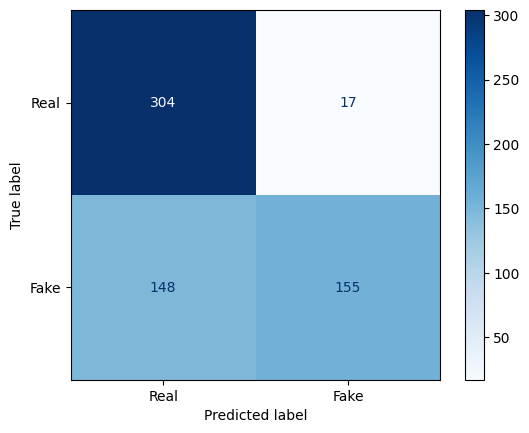

In [336]:
cm = confusion_matrix(y_true_aug, y_pred_aug)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.show()